In [1]:
# Install required libraries (if needed)
!pip install seaborn scikit-learn --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import fcluster, linkage

In [2]:
# Upload your CSV file (use Google Colab uploader)
from google.colab import files
uploaded = files.upload()

# Load the data
df = pd.read_csv(next(iter(uploaded)))
df.head()

Saving Combined_Clustering_Silhouettes.csv to Combined_Clustering_Silhouettes.csv


Name       Formula  DeltaMass         MW        m/z      RT  \
0      Piperine  C17 H19 N O3      -2.32  285.13583  286.14313  10.011   
1    Piperanine  C17 H21 N O3      -2.22  287.15151  288.15878   9.949   
2       Proline    C5 H9 N O2      -1.88  115.06311  116.07039   0.927   
3       Shogaol    C17 H24 O3      -2.47  276.17186  277.17914  10.541   
4  pedunculagin   C34 H24 O22      -2.42  784.07402  785.08130   5.823   

  Class of compounds  HC_Cluster  HC_Silhouette  PCA_Silhouette  PCA_Cluster  \
0           Alkaloid           2       0.140578        0.173569            3   
1           Alkaloid           2       0.177099        0.208482            3   
2         Amino Acid           2       0.518835        0.612689            1   
3       Polyphenolic           2       0.068375        0.141040            3   
4       Polyphenolic           1       0.131383        0.133931            2   

   OPLS_Silhouette  OPLS_Cluster  Average_Silhouette Silhouette_Category  
0         0.417254             3            0.243800                Poor  
1         0.424621             3            0.270067                Poor  
2         0.674300             1            0.601941           Excellent  
3         0.465420             3            0.224945                Poor  
4         0.524142             0            0.263152                Poor

In [3]:
# Drop unneeded columns if present
df.drop(columns=['Cluster'], errors='ignore', inplace=True)

# Fix duplicate OPLS cluster columns
if 'OPLS_Cluster_x' in df.columns and 'OPLS_Cluster_y' in df.columns:
    df['OPLS_Cluster'] = df['OPLS_Cluster_x']
    df.drop(columns=['OPLS_Cluster_x', 'OPLS_Cluster_y'], inplace=True)

# Rename columns consistently
df.rename(columns={
    'HC_Cluster': 'Cluster_HC',
    'PCA_Cluster': 'Cluster_PCA',
    'OPLS_Cluster': 'Cluster_OPLS'
}, inplace=True)

In [4]:
# Pick best silhouette method for each molecule
silhouette_cols = ['HC_Silhouette', 'PCA_Silhouette', 'OPLS_Silhouette']
df['Best_Clustering_Method'] = df[silhouette_cols].idxmax(axis=1)

# Assign final cluster based on best silhouette method
df['Final_Group'] = df.apply(
    lambda row: row['Cluster_HC'] if row['Best_Clustering_Method'] == 'HC_Silhouette'
    else row['Cluster_PCA'] if row['Best_Clustering_Method'] == 'PCA_Silhouette'
    else row['Cluster_OPLS'], axis=1
)

/tmp/ipython-input-5-1090924890.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_counts.index, y=group_counts.values, palette="viridis")


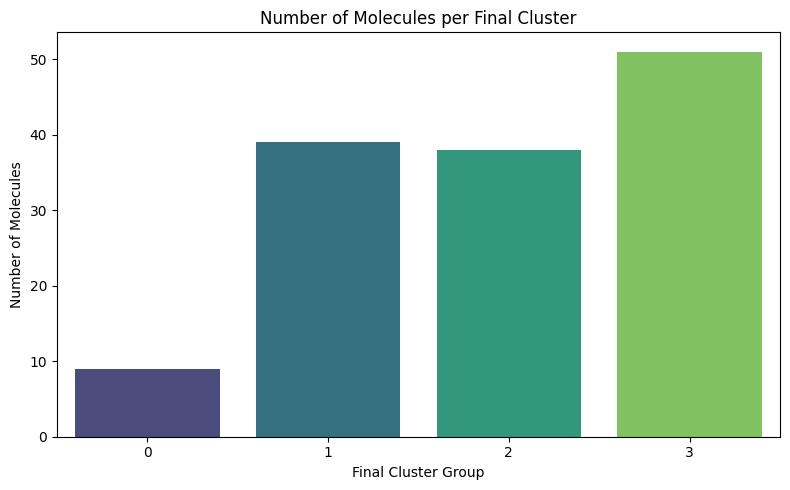

In [5]:
# Count molecules in each cluster
group_counts = df['Final_Group'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=group_counts.index, y=group_counts.values, palette="viridis")
plt.xlabel("Final Cluster Group")
plt.ylabel("Number of Molecules")
plt.title("Number of Molecules per Final Cluster")
plt.tight_layout()
plt.show()

In [6]:
# Group molecules by class within each final cluster
cluster_class_summary = df.groupby(['Final_Group', 'Class of compounds']).size().unstack(fill_value=0)
cluster_class_summary

Class of compounds  Alkaloid  Amino Acid  Carbohydrate  Flavonoid  Glycoside  \
Final_Group                                                                    
0                          1           0             0          3          0   
1                          0          12             4          0          0   
2                          5           5             1          4          2   
3                         12           2             0          9          0   

Class of compounds  Lipid  Polyphenolic  Terpenoid  carboxylic acid  other  
Final_Group                                                                 
0                       0             3          2                0      0  
1                       0            17          1                4      1  
2                       1            15          4                1      0  
3                       5            13         10                0      0

In [7]:
# Save full annotated dataset
df.to_csv("Final_Annotated_Molecule_Clusters.csv", index=False)
files.download("Final_Annotated_Molecule_Clusters.csv")

# Save grouped summary
cluster_class_summary.to_csv("Cluster_Class_Summary.csv")
files.download("Cluster_Class_Summary.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# Step 1: Define silhouette threshold
silhouette_threshold = 0.45  # You can raise this to 0.5 or 0.6 for stricter filtering

# Step 2: Filter molecules with strong clustering quality
top_biomarkers = df[df['Average_Silhouette'] > silhouette_threshold]

# Step 3: Keep relevant columns only (optional)
columns_to_keep = [
    'Name', 'Formula', 'MW', 'RT', 'Class of compounds',
    'Average_Silhouette', 'Silhouette_Category',
    'Final_Group', 'Best_Clustering_Method'
]
biomarker_df = top_biomarkers[columns_to_keep]

In [9]:
# Sort by silhouette score (descending)
biomarker_df = biomarker_df.sort_values(by='Average_Silhouette', ascending=False)

# Preview top 10
biomarker_df.head(10)

Name       Formula         MW  \
128                                   Aconitic acid      C6 H6 O6  174.01618   
105                                  (±)-Malic acid      C4 H6 O5  134.02140   
23                                D-(-)-Quinic acid     C7 H12 O6  192.06315   
113                             L-Pyroglutamic acid    C5 H7 N O3  129.04245   
42                                (Z)-Aconitic Acid      C6 H6 O6  174.01629   
102                                     Citric acid      C6 H8 O7  192.02681   
43                                    Glutaric acid      C5 H8 O4  132.04211   
54                                      DL-Arginine  C6 H14 N4 O2  174.11156   
112                                  Mesaconic acid      C5 H6 O4  130.02645   
103  1,3,4,5-Tetrahydroxycyclohexanecarboxylic acid     C7 H12 O6  192.06308   

        RT Class of compounds  Average_Silhouette Silhouette_Category  \
128  1.145       Polyphenolic            0.648470           Excellent   
105  0.974       Polyphenolic            0.645683           Excellent   
23   0.934       Polyphenolic            0.645289           Excellent   
113  1.163         Amino Acid            0.645250           Excellent   
42   1.129    carboxylic acid            0.645064           Excellent   
102  1.145       Polyphenolic            0.642114           Excellent   
43   0.867       Polyphenolic            0.638063           Excellent   
54   0.805         Amino Acid            0.636325           Excellent   
112  1.145       Polyphenolic            0.634537           Excellent   
103  0.921       Polyphenolic            0.631643           Excellent   

     Final_Group Best_Clustering_Method  
128            1        OPLS_Silhouette  
105            1        OPLS_Silhouette  
23             1        OPLS_Silhouette  
113            1        OPLS_Silhouette  
42             1        OPLS_Silhouette  
102            1        OPLS_Silhouette  
43             1        OPLS_Silhouette  
54             1        OPLS_Silhouette  
112            1        OPLS_Silhouette  
103            1        OPLS_Silhouette

In [10]:
# Save top biomarkers to CSV
biomarker_df.to_csv("Top_Biomarkers.csv", index=False)
files.download("Top_Biomarkers.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>